In [2]:
import json
import re
import time

from linkify_it import LinkifyIt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from tqdm import tqdm
import requests
import xmltodict

%reload_ext autoreload
%autoreload 2
sys.path.append('../scripts')
import pbmd_tools as pbmd

In [6]:
pbmd.read_tokens("../.env")
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
PUBMED_TOKEN = os.environ.get("PUBMED_TOKEN")

In [13]:
pbmd.query_pubmed(query='"github.com"[tiab:~0]', year_start=2009, year_end=2022, output_name="github")

,year,PMID
0,2010,21169373
1,2010,21124986
2,2010,20935049
3,2010,20798169
4,2010,20562450
...,...,...
11020,2022,32750861
11021,2022,32750860
11022,2022,32678794
11023,2022,32559172


In [3]:
linkify = (
    LinkifyIt()
    .set({"fuzzy_email": False}) 
)

In [40]:
pbmd.add_days("2023/03/24", 10)

'2023/04/03'

In [11]:
queries = []
for year in range(2009, 2023):
    queries.append(f'(("http"[Title/Abstract]) OR ("https"[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
df = pbmd.get_all_pmids(queries)

print(f"\n{len(df)} articles with 'http(s)' found in PubMed")

100%|██████████| 14/14 [04:07<00:00, 17.69s/it]


87768 articles with 'http(s)' found in PubMed


In [9]:
df.groupby(df['year']).size().reset_index(name='count')

,year,count
0,2009,2720
1,2010,3036
2,2011,3164
3,2012,3645
4,2013,4279
5,2014,4637
6,2015,4788
7,2016,5210
8,2017,5679
9,2018,6855


In [13]:
df.to_csv('../data/PMIDs.tsv', sep='\t', index=False)

In [12]:
PMIDs = df['PMID'].to_list()

In [16]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "xml"

In [17]:
for PMID in tqdm(PMIDs):
    url = f'{domain}/efetch.fcgi?db={db}&id={PMID}&retmode={retmode}&rettype=abstract&api_key={PUBMED_TOKEN}'  
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(f"../data/xml/{PMID}.xml", "wb") as file:
                file.write(response.content)
        else:
            print(f"{PMID} failed :", response.status_code)
    except:
        continue

  3%|▎         | 2624/87768 [29:39<30:23:02,  1.28s/it]

18854357 failed : 502


  3%|▎         | 2753/87768 [31:00<32:47:39,  1.39s/it]

21393795 failed : 400


  5%|▌         | 4563/87768 [50:43<33:24:09,  1.45s/it]

20529895 failed : 400


  6%|▌         | 5051/87768 [56:00<32:18:21,  1.41s/it]

20385020 failed : 400


  6%|▌         | 5175/87768 [57:15<32:10:00,  1.40s/it]

20299326 failed : 400


  7%|▋         | 5793/87768 [1:03:41<39:55:07,  1.75s/it]

22384322 failed : 400


 10%|█         | 9003/87768 [1:37:00<22:01:40,  1.01s/it]

23281809 failed : 500


 10%|█         | 9164/87768 [1:38:45<30:21:56,  1.39s/it]

23240086 failed : 400


 11%|█         | 9701/87768 [1:44:47<37:34:28,  1.73s/it]

23118925 failed : 400


 12%|█▏        | 10252/87768 [1:50:42<31:40:58,  1.47s/it]

22949472 failed : 400


 17%|█▋        | 15233/87768 [2:40:30<33:37:03,  1.67s/it]

23716633 failed : 400


 18%|█▊        | 15469/87768 [2:42:57<28:18:11,  1.41s/it]

23652697 failed : 400


 19%|█▉        | 16798/87768 [2:58:09<27:51:37,  1.41s/it] 

23271155 failed : 400


 19%|█▉        | 17114/87768 [3:01:20<33:15:45,  1.69s/it]

25510390 failed : 400


 20%|██        | 17692/87768 [3:06:59<27:01:01,  1.39s/it]

25359893 failed : 400


 27%|██▋       | 23903/87768 [4:09:17<14:58:45,  1.18it/s]

26140380 failed : 500


 35%|███▍      | 30672/87768 [5:17:48<23:17:52,  1.47s/it] 

26937654 failed : 400


 39%|███▉      | 34271/87768 [5:52:13<12:25:50,  1.20it/s]

28651291 failed : 500


 42%|████▏     | 36731/87768 [6:15:48<12:42:05,  1.12it/s]

28068987 failed : 500


 46%|████▌     | 40566/87768 [6:52:23<18:20:57,  1.40s/it]

29893754 failed : 400


 53%|█████▎    | 46861/87768 [7:50:30<15:53:30,  1.40s/it]

31370886 failed : 400


 54%|█████▎    | 47159/87768 [7:53:22<16:02:28,  1.42s/it]

31310539 failed : 400


 55%|█████▍    | 48091/87768 [8:02:00<15:34:07,  1.41s/it]

31142511 failed : 400


 55%|█████▌    | 48702/87768 [8:07:37<15:11:23,  1.40s/it]

31039763 failed : 400


 67%|██████▋   | 59229/87768 [9:49:04<78:26:54,  9.90s/it] 

33296240 failed : 502


 67%|██████▋   | 59235/87768 [9:49:09<15:50:24,  2.00s/it]

33294945 failed : 500


 69%|██████▉   | 60452/87768 [10:01:30<10:59:26,  1.45s/it]

33064602 failed : 400


 74%|███████▎  | 64674/87768 [10:42:01<9:17:55,  1.45s/it] 

33719338 failed : 400


 75%|███████▍  | 65466/87768 [10:49:54<9:36:35,  1.55s/it]

33573701 failed : 400


 76%|███████▌  | 66668/87768 [11:02:06<8:23:00,  1.43s/it]

33313665 failed : 400


 76%|███████▌  | 66896/87768 [11:04:21<8:37:16,  1.49s/it]

33119754 failed : 400


 77%|███████▋  | 67321/87768 [11:08:49<8:32:49,  1.50s/it] 

34536568 failed : 400


 77%|███████▋  | 67468/87768 [11:10:18<8:46:22,  1.56s/it]

34446489 failed : 400


 77%|███████▋  | 67757/87768 [11:13:43<7:46:05,  1.40s/it]

34383594 failed : 400


 78%|███████▊  | 68103/87768 [11:17:34<8:17:30,  1.52s/it]

34303360 failed : 400


 81%|████████  | 70659/87768 [11:42:53<7:04:02,  1.49s/it]

32255488 failed : 400


 82%|████████▏ | 71776/87768 [11:54:07<6:17:30,  1.42s/it]

34775781 failed : 400


 82%|████████▏ | 71817/87768 [11:54:33<6:17:19,  1.42s/it]

34763532 failed : 400


 86%|████████▌ | 75392/87768 [12:28:20<4:51:04,  1.41s/it]

36204368 failed : 400


 86%|████████▌ | 75542/87768 [12:29:45<4:43:53,  1.39s/it]

36129860 failed : 400


 86%|████████▋ | 75748/87768 [12:31:47<5:16:04,  1.58s/it]

36049454 failed : 400


 86%|████████▋ | 75749/87768 [12:31:49<5:05:20,  1.52s/it]

36048833 failed : 500


 87%|████████▋ | 75934/87768 [12:33:40<4:44:51,  1.44s/it]

35938015 failed : 400


 87%|████████▋ | 75976/87768 [12:34:05<4:36:47,  1.41s/it]

35924170 failed : 400


 87%|████████▋ | 76639/87768 [12:40:13<4:32:29,  1.47s/it]

35594250 failed : 400


 87%|████████▋ | 76766/87768 [12:41:27<4:17:34,  1.40s/it]

35536084 failed : 400


 88%|████████▊ | 77122/87768 [12:44:43<4:07:43,  1.40s/it]

35451938 failed : 400


 88%|████████▊ | 77462/87768 [12:47:52<3:58:11,  1.39s/it]

35397090 failed : 400


 89%|████████▊ | 77840/87768 [12:51:21<4:04:24,  1.48s/it]

35350598 failed : 400


 90%|█████████ | 79145/87768 [13:03:39<23:29:39,  9.81s/it]

35157600 failed : 502


 90%|█████████ | 79161/87768 [13:03:54<3:47:06,  1.58s/it] 

35157018 failed : 400


 91%|█████████ | 79641/87768 [13:08:29<3:09:18,  1.40s/it]

35085775 failed : 400


 96%|█████████▌| 84130/87768 [13:49:49<1:25:54,  1.42s/it]

35362024 failed : 400


 99%|█████████▉| 86944/87768 [14:15:35<19:17,  1.41s/it]  

36122583 failed : 400


100%|█████████▉| 87554/87768 [14:21:16<05:09,  1.45s/it]

35737911 failed : 400


100%|█████████▉| 87631/87768 [14:22:01<03:13,  1.41s/it]

35188180 failed : 400


100%|██████████| 87768/87768 [14:23:15<00:00,  1.69it/s]


In [20]:
PMIDs_failed = []

files = os.listdir('../data/xml')
for file in files:
    if file[-4:] != ".xml":
        files.remove(file)

PMIDs_succed = [file.split('.')[0] for file in files]

for id in PMIDs:
    if id not in PMIDs_succed :
        PMIDs_failed.append(id)
print(len(PMIDs))
print(len(PMIDs_succed))
print(len(PMIDs_failed))

87768
87768
0


In [19]:
for PMID in tqdm(PMIDs_failed):
    url = f'{domain}/efetch.fcgi?db={db}&id={PMID}&retmode={retmode}&rettype=abstract&api_key={PUBMED_TOKEN}'  
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(f"../data/xml/{PMID}.xml", "wb") as file:
                file.write(response.content)
        else:
            print(f"{PMID} failed :", response.status_code)
    except:
        continue

100%|██████████| 88/88 [00:46<00:00,  1.90it/s]


In [22]:
with_http = 0
without_http = 0
github_occur = 0

links_stat = {}

for file in files:
    with open(f"../data/xml/{file}", "r") as f:
        #summary = xmltodict.parse(f.read())
        #abstract = pbmd.get_abstract_from_summary(summary, "../data/log_files/status_all_links.txt")
        abstract = f.read()
    
        if abstract != None:

            if linkify.test(abstract):
                if 'github.com' in abstract:
                    github_occur += abstract.count('github.com')
                for match in linkify.match(abstract):
                    link = match.raw
                    if link.startswith('http://github') or link.startswith('https://github'):
                        with_http += 1
                    elif link.startswith('github'):
                        without_http += 1
                    try:
                        key = link.split('/')[2]
                    except:
                        try:
                            key = link.split('/')[0]
                        except:
                            key = link
                    if key in links_stat:
                        links_stat[key] += 1
                    else:
                        links_stat[key] = 1

In [23]:
len(links_stat)

23375

In [24]:
sum(links_stat.values())

110438

In [25]:
links_stat_lower = {}

for key in links_stat.keys():
    if key.lower() in links_stat_lower:
        links_stat_lower[key.lower()] += links_stat[key]
    else:
        links_stat_lower[key.lower()] = links_stat[key]

In [26]:
len(links_stat_lower)

23065

In [27]:
keys_to_modify = [key for key in links_stat_lower.keys() if key.startswith('www')]

for key in keys_to_modify:
    if key[4:] in links_stat_lower:
        links_stat_lower[key[4:]] += links_stat_lower[key]
    else:
        links_stat_lower[key[4:]] = links_stat_lower[key]
    links_stat_lower[key] = 0
    

In [28]:
keys_to_delete = [key for key, value in links_stat_lower.items() if value == 0]
for key in keys_to_delete:
    del links_stat_lower[key]

In [29]:
len(links_stat_lower)

22397

In [33]:
with open("../data/links_stat_lower.json", "w") as f:
    json.dump(links_stat_lower, f)

In [36]:
with open("../data/stats_github.json", "r") as f:
    stats_github = json.load(f)
with open("../data/stats_gitlab.json", "r") as f:
    stats_gitlab = json.load(f)
with open("../data/stats_sourceforge.json", "r") as f:
    stats_sourceforge = json.load(f)
with open("../data/stats_googlecode.json", "r") as f:
    stats_googlecode = json.load(f)
with open("../data/stats_bitbucket.json", "r") as f:
    stats_bitbucket = json.load(f)
with open("../data/PMIDs.txt", "r") as f:
    PMIDs = f.readlines()
PMIDs = [PMID.strip() for PMID in PMIDs]

In [34]:
forges_http = {'github.com': links_stat_lower['github.com'],
              'sourceforge.net': links_stat_lower['sourceforge.net'],
              'code.google.com': links_stat_lower['code.google.com'],
              'bitbucket.org': links_stat_lower['bitbucket.org'],
              'gitlab.com': links_stat_lower['gitlab.com']}

In [37]:
forges_no_http = {'github.com': sum(stats_github.values()),
                  'sourceforge.net': sum(stats_sourceforge.values()),
                  'code.google.com': sum(stats_googlecode.values()),
                  'bitbucket.org': sum(stats_bitbucket.values()),
                  'gitlab.com': sum(stats_gitlab.values())}

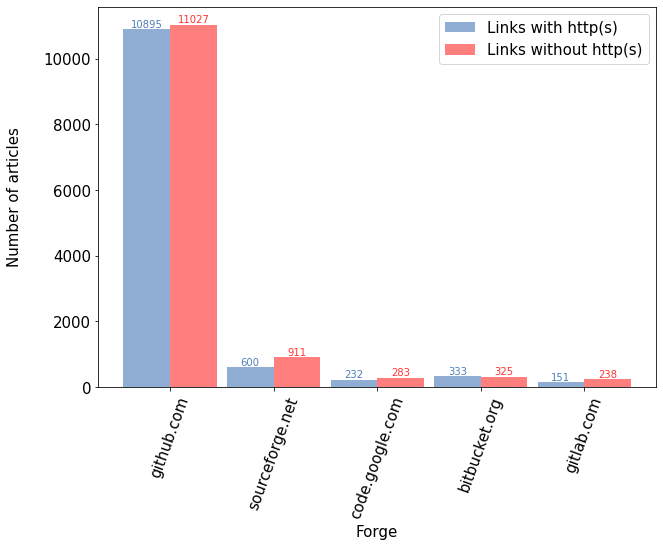

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))

forges = list(forges_http.keys())
values_http = list(forges_http.values())
values_no_http = list(forges_no_http.values())

bar_width = 0.45
x_pos = np.arange(len(forges)) 

ax.bar(x_pos - bar_width/2, values_http, color='#225ea8', alpha = 0.5, width=bar_width)
ax.bar(x_pos + bar_width/2, values_no_http, color='red', alpha = 0.5, width=bar_width)


ax.set_xlabel('Forge', fontsize=15, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=15, fontfamily='sans-serif')
#ax.set_title('Publications per year', fontsize=15, fontfamily='sans-serif')

# adding numbers for each point (if needed)

for i in range(len(forges)):
    ax.text(i-bar_width/2, values_http[i], str(values_http[i]), 
            ha='center', va='bottom', fontsize=10, color='#225ea8', alpha = 0.8)
    ax.text(i+bar_width/2, values_no_http[i], str(values_no_http[i]), 
            ha='center', va='bottom', fontsize=10, color='red', alpha = 0.8)


ax.legend([f"Links with http(s)", 
           f"Links without http(s)"], fontsize=15)

ax.set_xticks(x_pos)
ax.set_xticklabels(forges, fontsize=14, rotation=70)
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15) 

#plt.savefig("../data/images/stat_swh.png")
plt.show()

In [36]:
dict(sorted(links_stat_lower.items(), key=lambda x: x[1], reverse=True))

{'clinicaltrials.gov': 14670,
 'github.com': 9257,
 'doi.org': 6072,
 'links.lww.com': 2339,
 'dx.doi.org': 2028,
 'crd.york.ac.uk': 1947,
 'elsevier.com': 1533,
 'chictr.org.cn': 1255,
 'webcitation.org': 1232,
 'onlinelibrary.wiley.com': 1063,
 'osf.io': 863,
 'bit.ly': 850,
 'anzctr.org.au': 811,
 'youtu.be': 796,
 'ncbi.nlm.nih.gov': 736,
 'isrctn.com': 643,
 'diagnosticpathology.diagnomx.eu': 639,
 'sourceforge.net': 599,
 'trialregister.nl': 552,
 'cran.r-project.org': 534,
 'bioconductor.org': 470,
 'controlled-trials.com': 441,
 'ow.ly': 381,
 'umin.ac.jp': 360,
 '': 329,
 'irct.ir': 309,
 'ebi.ac.uk': 304,
 'bitbucket.org': 302,
 'drks.de': 299,
 'biomedcentral.com': 270,
 'tinyurl.com': 265,
 'europeanreview.org': 260,
 'cancerres.aacrjournals.org': 252,
 'cdc.gov': 235,
 'code.google.com': 232,
 'upload.umin.ac.jp': 207,
 'sites.google.com': 189,
 'proteomecentral.proteomexchange.org': 174,
 'rimed.org': 172,
 'clinicaltrialsregister.eu': 172,
 'cris.nih.go.kr': 170,
 'sprin

In [34]:
df = pd.read_csv('../data/articles.tsv', sep='\t')
abstracts = df['Abstract'].to_list()

with_http = 0
without_http = 0
links_stat = {}

for abstract in abstracts:
    if abstract != None:

        if linkify.test(str(abstract)):
            for match in linkify.match(str(abstract)):
                link = match.raw
                if link.startswith('http://github') or link.startswith('https://github'):
                    with_http += 1
                elif link.startswith('github') :
                    without_http += 1
                try:
                    key = link.split('/')[2]
                except:
                    try:
                        key = link.split('/')[0]
                    except:
                        key = link
                if key in links_stat:
                    links_stat[key] += 1
                else:
                    links_stat[key] = 1

In [35]:
with_http, without_http 

(10840, 329)